# 프로젝트: 새로운 데이터셋으로 나만의 이미지 분류기 만들어보기

## Step 1. 데이터셋 내려받기

https://www.tensorflow.org/datasets/catalog/tf_flowers?hl=ko

데이터 - 3,670장
 -> 데이터셋 크기가 작아 argumentation이 필요할지도 모르겠다  
레이블은 ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'] 5개

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(name='tf_flowers',
                                                           split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                           data_dir='~/aiffel/workplace/Exploration/flowers',
                                                           download=True,
                                                           with_info=True,
                                                           as_supervised=True)

## Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

이미지 데이터 타입을 float32로 변경하고  
0~1 사이로 rescale  
이미지 사이즈는 224, 224로 정함

In [4]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [6]:
get_label_name = metadata.features['label'].int2str
label_list = list(map(get_label_name, range(5)))
print(label_list)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


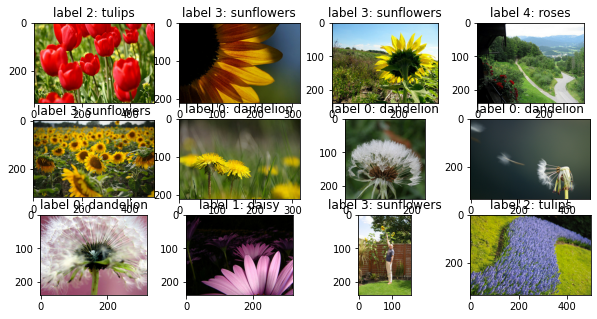

In [7]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(12)):
    plt.subplot(3, 4, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')

In [8]:
IMG_SIZE = 224

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


In [10]:
BATCH_SIZE = 32
train_batch = train.shuffle(1000).batch(BATCH_SIZE)
validation_batch = validation.batch(BATCH_SIZE)
test_batch = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batch.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32]))

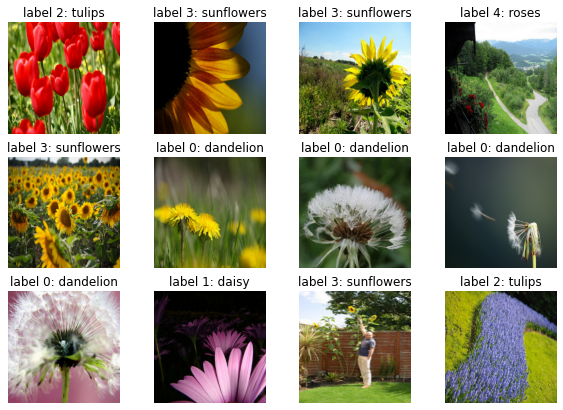

In [43]:
plt.figure(figsize=(10, 7))

for idx, (image, label) in enumerate(train.take(12)):
    plt.subplot(3, 4, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## Step 3. 모델 설계하기

지난 DLthon에서 좋은 성능을 발휘했던 mobilenet을 베이스 모델로 삼음  
데이터셋 크기가 작기 때문에 모델 전체 학습이나 Convolutional 계층을 일부 학습시키는 것은 어려울 것이라고 판단, classifier부분만 학습시키기로 결정

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [13]:
# base model로 mobilenet 사용

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                      include_top=False,
                                                      weights='imagenet')
model = Sequential([base_model,
                 GlobalAveragePooling2D(),
                 Dense(512, activation='relu'),
                 Dense(5, activation='softmax')])
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 2,916,421
Trainable params: 2,882,309
Non-trainable params: 34,112
_________________________________________________________________


## Step 4. 모델 학습시키기


In [14]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics = ['accuracy'])

In [15]:
history = model.fit(train_batch, 
                   epochs=20,
                   validation_data=validation_batch)

Epoch 1/20
92/92 [==============================] - 69s 251ms/step - loss: 0.4645 - accuracy: 0.8399 - val_loss: 0.7582 - val_accuracy: 0.7711
Epoch 2/20
92/92 [==============================] - 21s 220ms/step - loss: 0.1215 - accuracy: 0.9615 - val_loss: 0.6618 - val_accuracy: 0.8283
Epoch 3/20
92/92 [==============================] - 21s 224ms/step - loss: 0.0477 - accuracy: 0.9874 - val_loss: 0.7334 - val_accuracy: 0.8256
Epoch 4/20
92/92 [==============================] - 21s 226ms/step - loss: 0.0222 - accuracy: 0.9939 - val_loss: 0.5305 - val_accuracy: 0.8774
Epoch 5/20
92/92 [==============================] - 21s 222ms/step - loss: 0.0265 - accuracy: 0.9894 - val_loss: 0.6874 - val_accuracy: 0.8610
Epoch 6/20
92/92 [==============================] - 21s 226ms/step - loss: 0.0185 - accuracy: 0.9928 - val_loss: 0.9125 - val_accuracy: 0.8229
Epoch 7/20
92/92 [==============================] - 21s 224ms/step - loss: 0.0160 - accuracy: 0.9935 - val_loss: 0.5281 - val_accuracy: 0.8719

In [17]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

save_model_dir = os.getenv("HOME") + "/aiffel/workplace/Exploration/models"
    
model.save_weights(save_model_dir+'mobilenet')

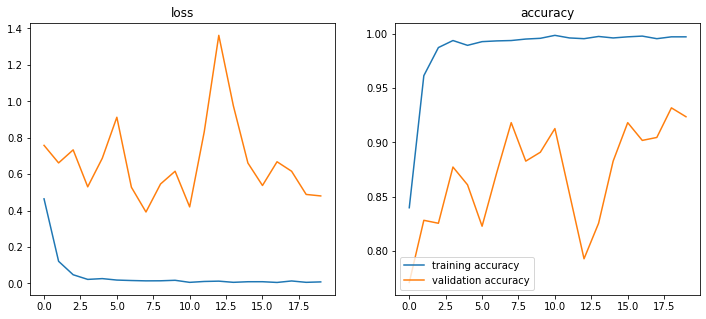

In [18]:
def plot_show(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    epochs = range(len(history.history['loss']))
    
    axes1 = plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='training loss')
    plt.plot(epochs, history.history['val_loss'], label='validation loss')
    plt.title('loss')
    
    axes2 = plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='validation accuracy')
    plt.title('accuracy')
    
    plt.legend()
    plt.show()

plot_show(history)

모델 학습의 결과 검증 
* loss가 상당히 불안정하게 학습됨 
    -> 옵티마이저의 영향일까?  
* accuracy는 90% 초반 정도에서 마무리 됨  
* 학습 후반에 accuracy가 올라가는 것을 보아서는 epoch을 몇번 더 진행하면 더 좋은 결과가 나올 수도 있었을 것 같다  
* DLthon에서는 97%까지 올라갔던 것에 비해 좀 아쉬운 성능 
     * 이진 분류에서 다중 분류가 되면서 난이도가 살짝 올라간 영향이 있었을 것
     * 데이터셋 크기가 작은 것도 영향이 되었을 것  
 
성능을 높이기 위해서는  
 1. epoch을 조금 더 높여보기
 2. 데이터셋 크기를 보완하기 위한 데이터 증강 기법 사용해보기 


## Step 5. 모델 성능 평가하기

In [19]:
pred = model.predict(test_batch)
pred_label = pred.argmax(axis=1)
pred_label

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 3, 4, 2, 0,
       1, 0, 1, 3, 1, 4, 4, 3, 0, 4, 4, 4, 2, 1, 4, 0, 1, 3, 4, 3, 3, 1,
       1, 1, 0, 0, 4, 2, 4, 0, 4, 1, 1, 2, 4, 4, 1, 2, 4, 3, 3, 1, 0, 1,
       3, 2, 3, 3, 2, 2, 4, 2, 0, 3, 1, 2, 2, 0, 4, 4, 1, 4, 0, 2, 2, 2,
       4, 1, 2, 0, 1, 1, 3, 3, 3, 3, 2, 0, 3, 2, 4, 4, 2, 0, 3, 2, 2, 1,
       2, 4, 2, 1, 4, 0, 2, 0, 1, 2, 4, 1, 4, 2, 2, 2, 3, 0, 3, 3, 0, 4,
       4, 1, 3, 3, 2, 1, 2, 4, 3, 1, 3, 2, 1, 4, 3, 0, 3, 2, 2, 4, 4, 0,
       0, 3, 2, 0, 4, 1, 2, 4, 4, 1, 1, 3, 4, 2, 3, 1, 0, 2, 4, 4, 2, 2,
       4, 1, 0, 3, 3, 4, 3, 2, 4, 4, 1, 3, 3, 2, 1, 0, 0, 2, 2, 2, 4, 1,
       0, 0, 1, 0, 2, 2, 0, 1, 3, 1, 0, 2, 2, 2, 3, 3, 3, 4, 1, 0, 2, 3,
       2, 3, 3, 4, 2, 2, 0, 0, 1, 2, 0, 2, 4, 3, 2, 3, 1, 3, 2, 0, 2, 3,
       3, 1, 3, 1, 4, 4, 3, 1, 2, 0, 4, 0, 3, 2, 0, 0, 3, 1, 1, 4, 0, 4,
       3, 2, 1, 1, 0, 4, 0, 3, 0, 0, 1, 4, 2, 1, 0, 4, 2, 2, 2, 3, 0, 3,
       3, 3, 2, 3, 1, 4, 3, 3, 1, 1, 0, 0, 1, 3, 0,

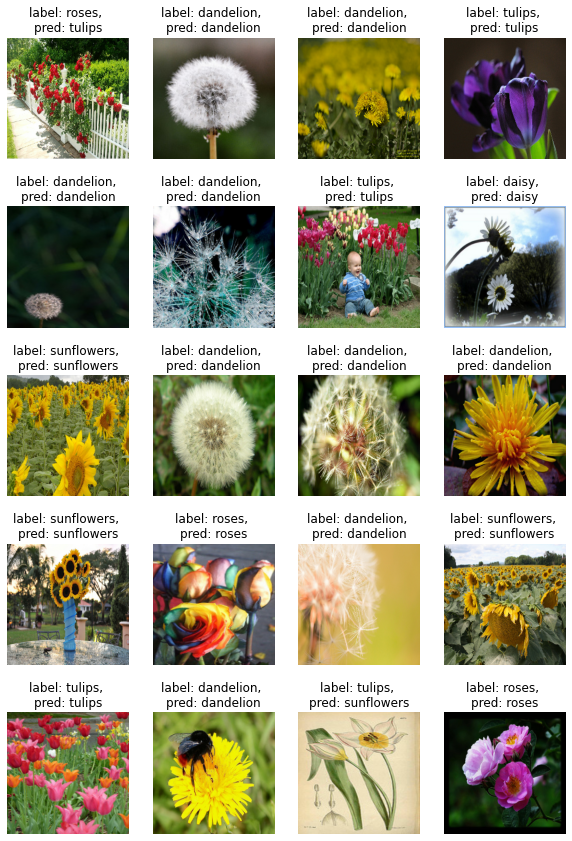

In [26]:
plt.figure(figsize=(10, 15))

for idx, (image, label) in enumerate(test.take(20)):
    plt.subplot(5, 4, idx+1)
    plt.imshow(image)
    plt.title(f'label: {get_label_name(label)}, \npred: {get_label_name(pred_label[idx])}')
    plt.axis('off')

In [32]:
count = 0
total = 0
for idx, (image, label) in enumerate(test.take(-1)):
    if label == pred_label[idx]:
        count += 1
    total += 1

test_accuracy = count/total

print(f'total test images: {total}, correct images: {count}, accuracy: {test_accuracy}')

total test images: 367, correct images: 338, accuracy: 0.9209809264305178


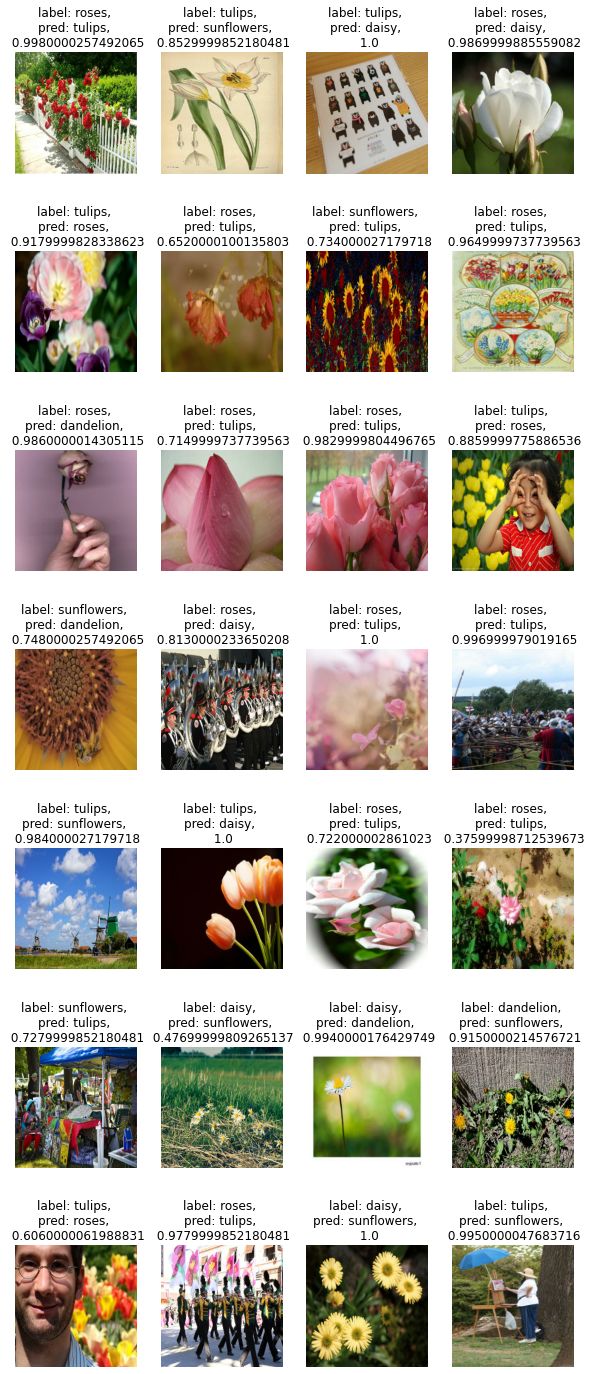

In [125]:
import numpy as np

i = 0
plt.figure(figsize=(10, 25))

for idx, (image, label) in enumerate(test.take(-1)):
    if label != pred_label[idx]:    
        plt.subplot(7, 4, i+1)
        plt.imshow(image)
        predicted_label = pred_label[idx]
        probability = pred[idx][predicted_label]
        plt.title(f'label: {get_label_name(label)}, \npred: {get_label_name(predicted_label)}, \n {round(probability, 3)}')
        plt.axis('off')
        i += 1
        if i == 28:
            break
plt.show()


## Step 6. 모델 활용하기

In [58]:
import matplotlib.pyplot as plt
import tempfile 
from six.moves.urllib.request import urlopen
from six import BytesIO

import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

In [107]:
def display_image(image):
    fig = plt.figure(figsize=(15, 10))
    plt.grid(False)
    plt.imshow(image)


In [108]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False): 
  
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)  # 이미지 읽기
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
    pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
    pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename

In [109]:
image_url = "https://ifh.cc/g/8VZoRH.jpg"

In [110]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

img = load_img(downloaded_image_path)

In [111]:
def image_prediction(image_url):
    img_path = download_and_resize_image(image_url, 224, 224, True) 
    img = load_img(img_path)
    img = tf.cast(img, tf.float32)
    img = img/255.0
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.reshape(img, [-1, IMG_SIZE, IMG_SIZE, 3])
    
    prediction = model.predict(img)
    prediction_label = prediction.argmax()
    pred_label = get_label_name(prediction_label)
    print(f'prediction: {pred_label}')

Image downloaded to /tmp/tmp5tadhfmm.jpg.
prediction: sunflowers


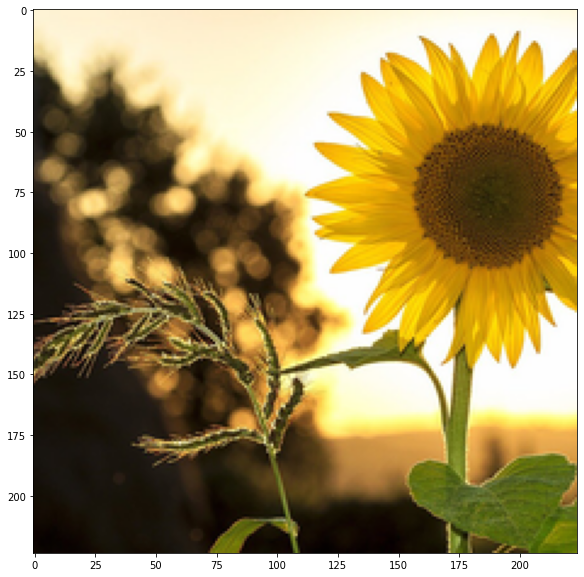

In [112]:
image_prediction("https://ifh.cc/g/8VZoRH.jpg")

Image downloaded to /tmp/tmp61v4e0i6.jpg.
prediction: tulips


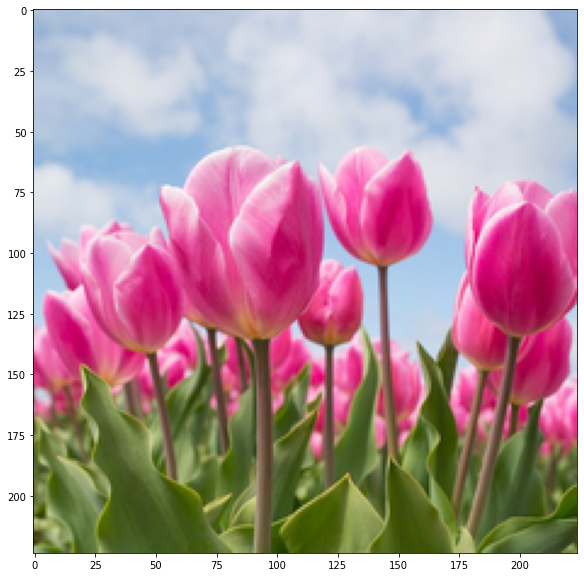

In [113]:
image_prediction("https://ifh.cc/g/nkPrB7.jpg")

Image downloaded to /tmp/tmph53_518s.jpg.
prediction: sunflowers


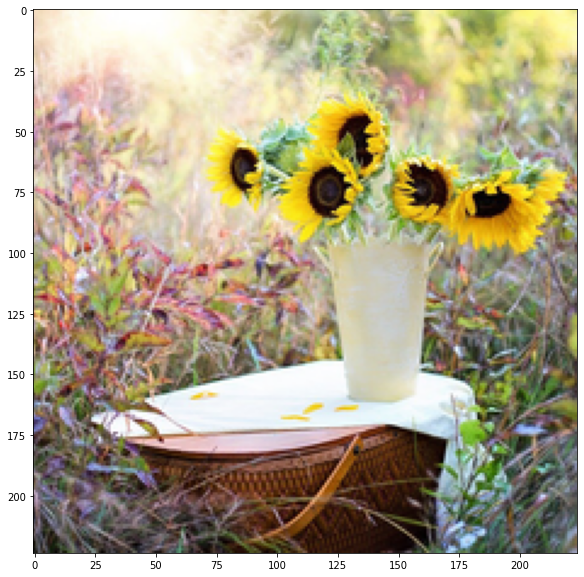

In [114]:
image_prediction("https://ifh.cc/g/2fP0PH.jpg")

Image downloaded to /tmp/tmp0la9uo18.jpg.
prediction: roses


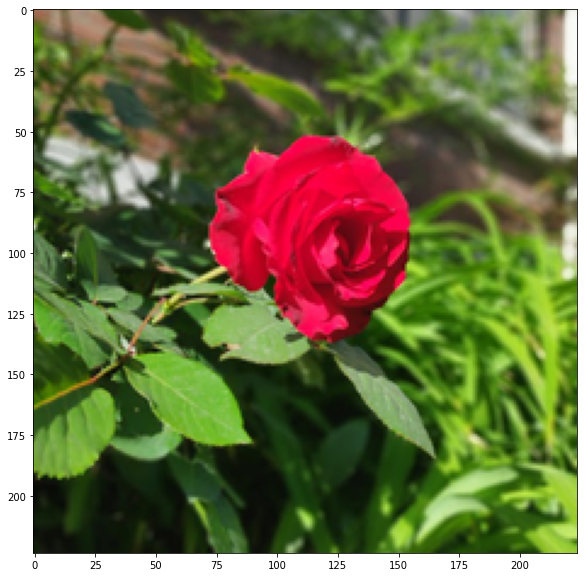

In [115]:
image_prediction("https://lh3.googleusercontent.com/pw/AIL4fc9XWxicQodF8orupiuaSDASSjKlqj7wDWmlDpflQEt0aGjAOUHVTtGaD6zk821ny450WhLtW-5OvMjQT2ZfrdZjqHFOsj3JbYatGvTFYsImGrK7FcmBBj58AqNQJ49eZGOSNXjwWf3abZ3PL2_xgS75-Ehm-nujCGJUKcM2g9j9gbZ4i3fKQIOWexUiOqA1LRLppWPLSpE8sudZ3VxC6zQAiL90fbGWZ4lqDNYPcslP3Fsvz-JF-sgCIthTRjYRbhWCD50lxeUcC1wzH4DGYJxd9H6jGMn5NKjUJrFIUstOcVb_5zJFTgHfrxMO8IdKILSC8s034foSiec0tTzi_gSzxjliOiKyeI6-7RxMBNU1jFbiChBVRxmIIBu6jGMG7nqiFu_s4aGQe6nul_bCVNebU8D5QwXYxYzLrY3Q02GFtF2I5KU0MsGosBbWsVnx8TuilMefCxSmjN4DwX7UKrUiDXDHtVM-rIMceTwoAjJr6HcT94Gt078UfvqEigMwq-z3KSO7sjqgSjfjWhku_PMKCmkuFae-EchewTFLu4zn2X5xDbQ9WpMZiTOSbTri-GuHKlC5hy71IgFWzOO_Y5mQWXthZSuVFSqiTjJTJCvK_wdei-lea1-S3dvA7Limg3gBKApcxyCplPa_fKq9xmhJjhk95OSfkJvM-8X92wQELGNIOoWvuwRyL_CDPUM8estANs7rIJN3nOdchBDRhGIpVTuXPikMjYA8LcNLuJwAppk4uTIcIRWz-fjS7q67d0GH849dT_REIqB8DIdJSd5s8n90uXOzloOi31XKuszbHKgduDGD2tevhCE5fP5tJZNxc4E5uhvc6bRjxBljACfRZ1ncyYm7zt85zYA5Gz6QjA6MyF31AUjGLFUCr2CRMVAB1e_wsZZwUAcQ9cJrtY29Suo=w508-h903-s-no?authuser=0")

Image downloaded to /tmp/tmp4nafsudr.jpg.
prediction: tulips


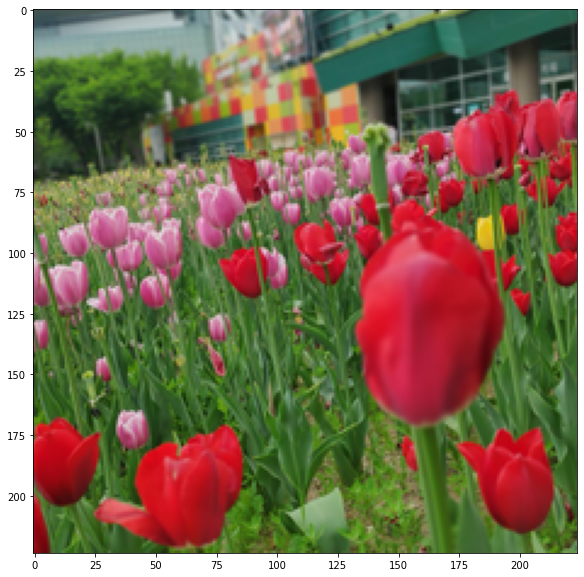

In [116]:
image_prediction("https://lh3.googleusercontent.com/pw/AIL4fc9JkppNxKlTDYmXlFywNiERjqWB64gipZk4-QyYGsHGFYVc_3yhxrpF0_7U58PbvjuPCJjl8b9rpmFMC64wY55brUgvScsVaeJ_drlRyUMXB6KKe_8_jEIiiJS-jXJ62YnZjD-5FnlSxPZF83QwDgSUH_gfOkoF4xJTrVqmyIyl6xH03bsVcv6pqMmVfsznZRcoed2S2a9SG99VbSGQ6gYke7hGqoNpDZIfDZK9fLkpOY3oox03mejvXQdX1s4aODq8PY9EQ41ROjMrOWU1NBZh97Pp5jdhzmXoVDNCha1MV2hjA3Wx3rz9vRst7OLYdYeFRitdmZZgyZfBQgQASjLPE4I2X_oGyoiw0R3K-cxQoWD_8ESIg4ZBolwZ8CYaOTdolg8mnED8CzzE0V2y1_BgaFEnzx5OQPP6Cca4kMYONeRx0GUn6wDqQbW6uohCLxWBPh2OjiQ1BNacQMsydm9tK4aSORLQtFwGP8xxQb4-L6qaqcQyj3JBkKNFe9zLUMKWaU74TLTRH5K7XagHCAFN-VRajLrznuA2o8Z4j3jTjzxg_1VHzaO27zu1ZdkZycA_-KDDRk3jKZyv3dNCPZan-taq8arSgM4K1mHdOYOoHi3Jzz6ywBA97t-1M5kFCkG8Xq5M76ZXBWZTkt7peJkKOCkgTTcKdx2x_-n2g0kBXrGvaVUUVJUSZnvOaQR5HhlYCo5KG3wTJax693fFtnqJDyabdr3Kc_uFU3FlGOpGzD7x2_uH5uXjI5VAHFupJ7Eby3rUE_8n361KqOyfq90sB4aS7yA1zkY0-fSGouEtsGsuMCN6mxKdcp3K-kS5Qx4EIi-Rz1-hSofZarPFXPnixiPYnW-plICrJw9SypmgsrGSy7Af_KXrkblQxO5MJQs1J13cZEJvgEp-E_BxyJGGRho=w1605-h903-s-no?authuser=0")

Image downloaded to /tmp/tmpn0zfweds.jpg.
prediction: tulips


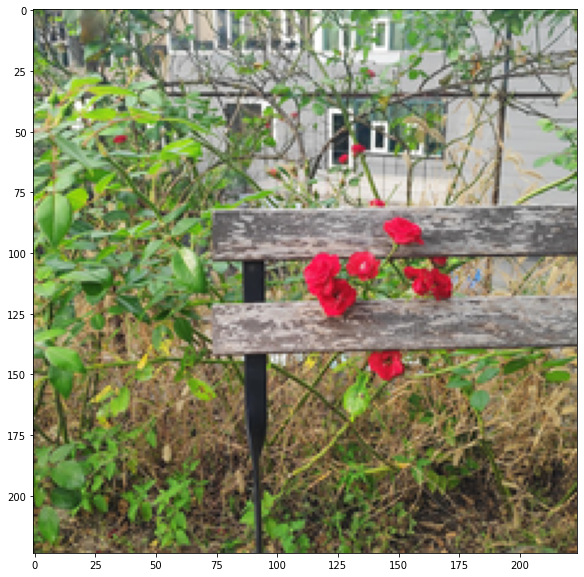

In [117]:
image_prediction("https://lh3.googleusercontent.com/pw/AIL4fc-O5FLzHq_g9TLi4LBQb5-9NH1JnZunNSSvHkniI4kGe2HLMr8dZGdDj6xkZRn10TGJX-zb_KVgHq5fz8zyTwM2Q43ln0DeyizErEHkYz-JYpecBztz359aeVhJX-rR9TZ8zT1emqZmia0E-mzFt0ywcKxKNOThiJp9NPkd-vgQtmpRBt2Dsicpwhmx0q3VHgp7PGirN3MWqFQWOwUrL6Pd8A-lnM7nm3I7P7cahmcQft9uXPIPRsNeE7OzL4F1KTYFq1X3Xg7lT_VHV32BVwKe6IGoZJnMhwmCb6kAhrKTnATtu4-g-nZc_IQABkbQYqSC05ou38XvDBIh-qYTLt514XprlefqsOhBftRKomN6kfQsVtJYMtc8izM4JF4a2-zhmFopeQHpAN50Hj2Qd6ORYFXzSNhxUI8ZTwI7Mcx1meIAkTtZoKPM4IwyveZYdgOey-yWwBveS29BxYD9K6Y1zQCOqCmNMM7yN95D4IXRX5DarrrudPn-LR8KwrRuhHau8EGd9kJ6JHiBHNAuOdrm7KrMoEbhK0j7dc2yGxipOqvlt_vxM-SE_DySoPLrfrJPYx8m2Ru34bszS1TQykEpRellvTQR1uSRAW-y2gSYYYlQzY067Ci8MyzvCYAb2TFe_ubTXgWbYBVGhUhbGOJfRslpnf8i5RKNPLJ1D2C88-slKueT8DaiNGfMwJulV86N4-di3FdOEOGTTNhkhw8Mq5WDUX34z-tc2i_-rhg0JMb8KvaGL2H9YAzDKyf3YTjwA6loCnNk0HCQjnr4hwL3G8XAiNpbdLnhfi23dtHA9NbPa7US-4ay9TItKwgPPT-AOnHDZCOEgFTk1e-1WDhSaEOyWsRmi0LgkLjpDlSsSaXCNxECDaWgCO9FOuulpJeuORe3KJNdUGNZyIx_hi7dh1o=w1605-h903-s-no?authuser=0")